# **Import Required Libraries**

In [1]:
import zipfile
from google.colab import drive
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

2025-10-10 14:32:09.685831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760106729.921301      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760106729.980311      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Preparation**

In [2]:
!gdown "https://drive.google.com/uc?id=1OcC1TwCdaOtliCaxPCtmruivX66cjNBF" -O ShopData.zip

import zipfile, os
with zipfile.ZipFile("ShopData.zip", 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working/ShopData")

data_dir = "/kaggle/working/ShopData/Shop DataSet"
shop_dir = os.path.join(data_dir, "shop lifters")
non_shop_dir = os.path.join(data_dir, "non shop lifters")

print(len(os.listdir(shop_dir)), "shop lifter videos")
print(len(os.listdir(non_shop_dir)), "non-shop lifter videos")

Downloading...
From (original): https://drive.google.com/uc?id=1OcC1TwCdaOtliCaxPCtmruivX66cjNBF
From (redirected): https://drive.google.com/uc?id=1OcC1TwCdaOtliCaxPCtmruivX66cjNBF&confirm=t&uuid=aa1a3ad4-cc38-4466-83cb-a236b2aa70f5
To: /kaggle/working/ShopData.zip
100%|██████████████████████████████████████| 1.78G/1.78G [00:18<00:00, 96.6MB/s]
324 shop lifter videos
531 non-shop lifter videos


# **Data PreProcessing**

In [3]:
N_FRAMES = 40
IMG_SIZE = (64, 64)

def load_video_frames(video_path, n_frames=N_FRAMES, augment=False):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    step = max(total_frames // n_frames, 1)

    for i in range(0, total_frames, step):
        if len(frames) >= n_frames:
            break
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, IMG_SIZE)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if augment:
            augmented = augmentor(image=frame)
            frame = augmented["image"]

        frames.append(frame)

    cap.release()

    while len(frames) < n_frames:
        frames.append(frames[-1])

    frames = np.array(frames) / 255.0
    return np.array(frames)

# EX
sample_video = os.path.join(shop_dir, os.listdir(shop_dir)[0])
frames = load_video_frames(sample_video)
print("Final shape:", frames.shape)

Final shape: (40, 64, 64, 3)


In [ ]:
X = []
Y = []

# shop lifters = 1
for file in tqdm(os.listdir(shop_dir), desc="Shop Lifters"):
    path = os.path.join(shop_dir, file)
    X.append(load_video_frames(path))
    Y.append(1)

# non-shop lifters = 0
for file in tqdm(os.listdir(non_shop_dir), desc="Non Shop Lifters"):
    path = os.path.join(non_shop_dir, file)
    X.append(load_video_frames(path))
    Y.append(0)

X = np.array(X)
Y = np.array(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

Non Shop Lifters: 100%|██████████| 531/531 [00:20<00:00, 26.17it/s]


X shape: (855, 40, 64, 64, 3)
Y shape: (855,)


# **Data Augmentation & Visualization**

In [5]:
import albumentations as A
augmentor = A.Compose([ 
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.4), 
    A.Rotate(limit=10, p=0.4), 
    A.GaussianBlur(p=0.3), 
    A.HueSaturationValue(p=0.3) 
])

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print("Train set:", X_train.shape, Y_train.shape)
print("Test set:", X_test.shape, Y_test.shape)

X_train_aug = [] 
for video in tqdm(X_train, desc="Augmenting Train Videos"): 
    augmented_video = np.array([ 
        augmentor(image=(frame * 255).astype(np.uint8))["image"] / 255.0 for frame in video ]) 
    X_train_aug.append(augmented_video) 
    
X_train = np.array(X_train_aug)

Train set: (684, 40, 64, 64, 3) (684,)
Test set: (171, 40, 64, 64, 3) (171,)


Augmenting Train Videos: 100%|██████████| 684/684 [00:10<00:00, 65.10it/s]


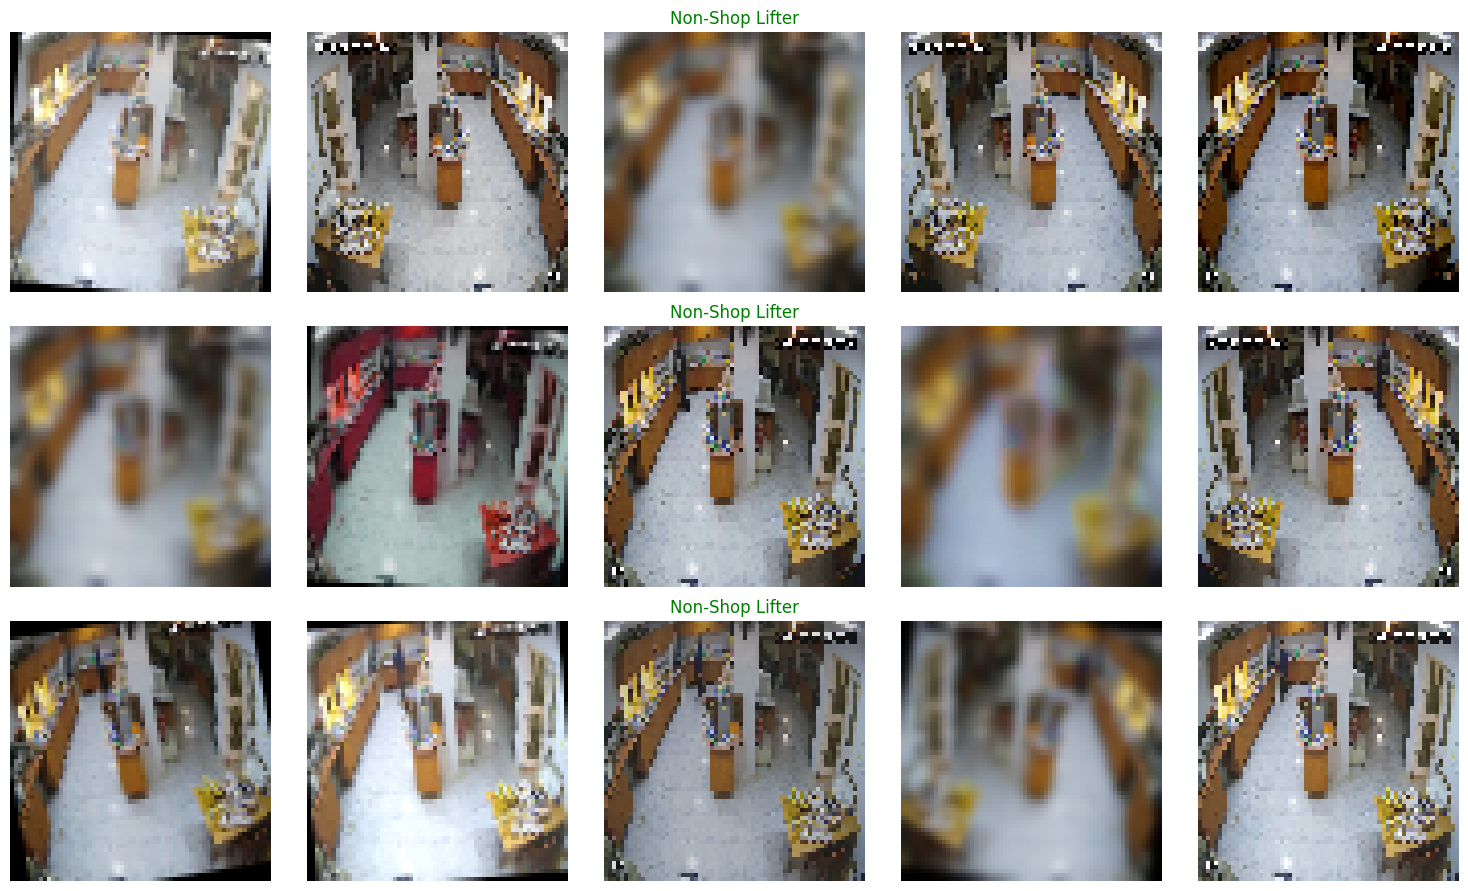

In [7]:
import random

def visualize_video_frames(X, Y, n_videos=3):
    plt.figure(figsize=(15, n_videos * 3))

    for i in range(n_videos):
        idx = random.randint(0, len(X) - 1)
        frames = X[idx]
        label = "Shop Lifter" if Y[idx] == 1 else "Non-Shop Lifter"

        frame_indices = np.linspace(0, len(frames)-1, 5, dtype=int)

        for j, f_idx in enumerate(frame_indices):
            plt.subplot(n_videos, 5, i*5 + j + 1)
            plt.imshow(frames[f_idx])
            plt.axis('off')
            if j == 2:
                plt.title(label, fontsize=12, color='red' if Y[idx]==1 else 'green')

    plt.tight_layout()
    plt.show()

visualize_video_frames(X_train, Y_train, n_videos=3)

# **Modeling**

In [8]:
n_frames = 40
img_size = 64
channels = 3

model_cnn_lstm = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=(n_frames, img_size, img_size, channels)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Flatten()),

    LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.3),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_cnn_lstm.compile(optimizer=Adam(5e-5), loss='binary_crossentropy', metrics=['accuracy'])
model_cnn_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1760106823.761948      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760106823.762712      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 40, 64, 64, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 40, 64, 64, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 40, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 40, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 40, 32, 32, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 40, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 40, 16, 16,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 40, 16, 16,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 40, 8, 8, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 40, 8192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     4,260,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,362,817 (16.64 MB)

 Trainable params: 4,362,369 (16.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
history = model_cnn_lstm.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10,
    batch_size=2
)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 71s 206ms/step - accuracy: 0.6725 - loss: 0.5901 - val_accuracy: 0.8129 - val_loss: 0.5656
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 69s 202ms/step - accuracy: 0.8134 - loss: 0.4534 - val_accuracy: 0.9181 - val_loss: 0.4272
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 69s 202ms/step - accuracy: 0.8339 - loss: 0.4081 - val_accuracy: 0.9181 - val_loss: 0.3145
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 69s 202ms/step - accuracy: 0.9021 - loss: 0.3326 - val_accuracy: 0.9240 - val_loss: 0.3349
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 69s 202ms/step - accuracy: 0.9340 - loss: 0.2531 - val_accuracy: 0.9649 - val_loss: 0.2315
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 69s 202ms/step - accuracy: 0.9620 - loss: 0.1858 - val_accuracy: 0.9883 - val_loss: 0.1446
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 69s 202ms/step - accuracy: 0.9738 - loss: 0.1126 - val_accuracy: 1.0000 - val_loss: 0.1209
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 69s 202ms/step - accuracy: 0.9893 - loss: 0

# **Evaluation**

In [11]:
test_loss, test_acc = model_cnn_lstm.evaluate(X_test, Y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 1.0000 - loss: 0.0420
Test Accuracy: 1.0000
Test Loss: 0.0409


6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step 


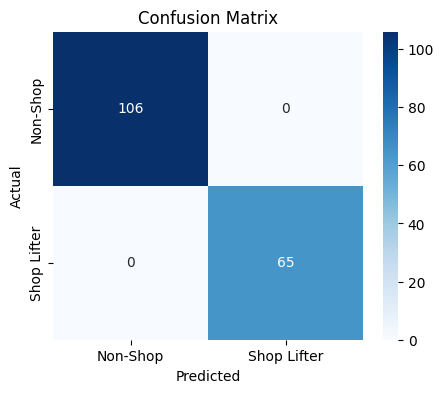


Classification Report:
              precision    recall  f1-score   support

    Non-Shop       1.00      1.00      1.00       106
 Shop Lifter       1.00      1.00      1.00        65

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Y_pred = (model_cnn_lstm.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Shop", "Shop Lifter"],
            yticklabels=["Non-Shop", "Shop Lifter"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=["Non-Shop", "Shop Lifter"]))

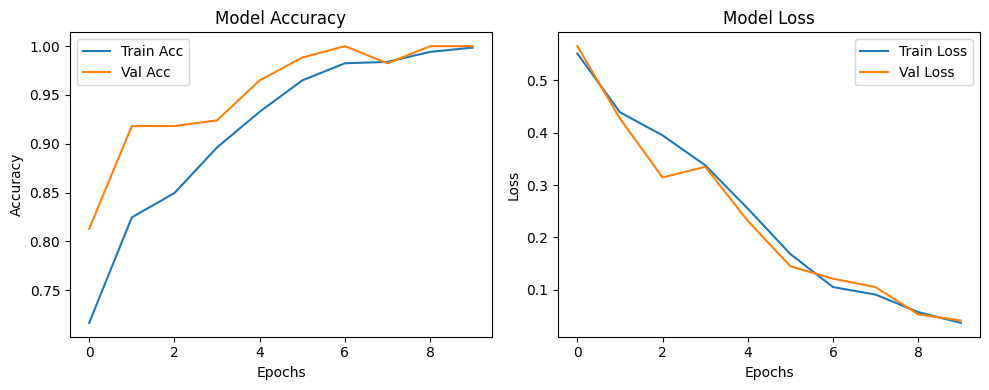

In [13]:
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()